## T5 трансформер для перевода с немецкого на английский

Сегодня вы поработаете над настоящей задачей NLP и попробуете обучить трансформер переводить короткие предложения с английского на немецкий.

Токенизацию и блоки трансформера писать не придётся — будем пользоваться библиотекой `transformers`.

Наши задачи:
- Познакомиться с наиболее популярным методом токенизации текстов — byte pair encoding
- Научиться пользоваться токенизатором из `transformers`
- Подготовить даннные
- Обучить готовую архитектуру T5-small под нашу задачу
- Исследовать разные стратегии декодирования с помощью обученной модели

In [1]:
import math
from pathlib import Path
from typing import cast

import lightning as L
import torch
import torch.nn.functional as F
from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset
from transformers import T5ForConditionalGeneration, T5Tokenizer

from datasets import load_dataset, load_from_disk

In [2]:
torch.manual_seed(42)

#### Готовим данные

In [3]:
train_dataset = load_dataset("bentrevett/multi30k", split="train")
test_dataset = load_dataset("bentrevett/multi30k", split="test")

In [4]:
train_dataset[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

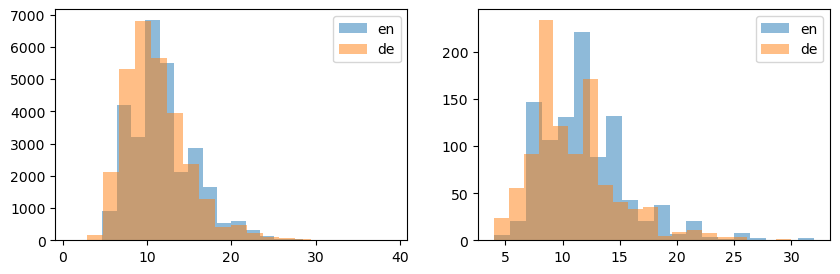

In [5]:
import matplotlib.pyplot as plt


def length_histogram(dataset, ax, bins=20) -> None:
    en_lengths = []
    de_lengths = []
    for sample in dataset:
        en_lengths.append(len(sample["en"].split(" ")))
        de_lengths.append(len(sample["de"].split(" ")))

    ax.hist(en_lengths, alpha=0.5, bins=bins, label="en")
    ax.hist(de_lengths, alpha=0.5, bins=bins, label="de")
    ax.legend()


fig, axes = plt.subplots(1, 2, figsize=(10, 3))
length_histogram(train_dataset, axes[0])
length_histogram(test_dataset, axes[1])

Оставим только сравнительно короткие предложения, чтобы можно было чему-то научиться за короткое время

In [6]:
maxlen = 8

def filter_dataset(dataset, maxlen: int) -> list[dict[str, str]]:
    return [
        dataset[i]
        for i in range(len(dataset))
        if len(dataset[i]["en"].split(" ")) <= maxlen
    ]


train_filtered = filter_dataset(train_dataset, maxlen)
test_filtered = filter_dataset(test_dataset, maxlen)

print(len(train_filtered), len(test_filtered))

5144 174


##### Токенизация: byte-pair encoding

Построение:

Начинаем со словаря, состоящего из отдельных символов (начальные токены).
На каждом шаге:
1. Оцениваем частоту всех пар токенов внутри слов, находим самую частую
2. Добавляем её в список токенов и в таблицу слияний
3. Останавливаемся, когда достигаем максимального размера словаря


Применение:

1. Разбиваем текст на символы
2. Находим первое возможное слияние в таблице и применяем его
3. Останавливаемся, когда дальнейшие слияния невозможны

<img src="https://lena-voita.github.io/resources/lectures/seq2seq/bpe/build_merge_table.gif" style="background:white" height="300"/>
<img src="https://lena-voita.github.io/resources/lectures/seq2seq/bpe/bpe_apply.gif" style="background:white" height="300"/>


Реализаций много, мы будем использовать токенизатор  из библиотеки `transformers`, где помимо самого подготовленного токенизатора (`sentencepiece.SentencePieceProcessor`) много полезных методов для кодирования и декодирования.

Добавим при создании новый токен, который будет указывать на начало перевода

In [7]:
tokenizer: T5Tokenizer = T5Tokenizer.from_pretrained(
    "t5-small", padding_size="right", bos_token="</b>", legacy=False
)

In [8]:
print("Размер словаря: ", len(tokenizer))

Размер словаря:  32101


Посмотрим на примеры токенов, в них встречаются и целые слова из разных языков, и числительные, и знаки препинания:

In [9]:
import random

random.choices(list(tokenizer.get_vocab().items()), k=10)

[('HY', 15761),
 ('▁Pres', 10131),
 ('▁après', 3308),
 ('▁Berater', 30294),
 ('buch', 5671),
 ('ständ', 17955),
 ('▁Kentucky', 13401),
 ('datele', 12918),
 ('WOOD', 29637),
 ('vapeur', 30951)]

Токенизатор в работе: кодирование и декодирование предложений на немецком и английском:

In [10]:
encoded_german = tokenizer.encode(train_dataset[0]["de"])
encoded_english = tokenizer.encode(train_dataset[0]["en"])
print(encoded_german)
print(tokenizer.decode(encoded_german))
print(encoded_english)
print(tokenizer.decode(encoded_english))

[11280, 16815, 7838, 15, 16282, 436, 256, 8671, 35, 16, 74, 13271, 2221, 49, 21162, 3992, 5, 1]
Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.</s>
[2759, 1021, 6, 1945, 5069, 7, 33, 1067, 1084, 186, 3, 30271, 5, 1]
Two young, White males are outside near many bushes.</s>


Об упаковке в батчи можно больше не беспокоиться — токенизатор умеет обрабатывать сразу пачку примеров

In [11]:
batch = [train_dataset[i]["en"] for i in range(4)]

encoded_batch = tokenizer.batch_encode_plus(
    batch, padding="longest", return_tensors="pt"
)
print(encoded_batch["input_ids"].shape)
print(encoded_batch.keys())

torch.Size([4, 19])
dict_keys(['input_ids', 'attention_mask'])


Возвращается два значения: `input_ids` — это наши токены, а `attention_mask` — это тензор, равный по размеру батчу токенов, где на месте `pad_token` стоят нули, в остальных позициях — единицы. Это нам понадобится потом.

А ещё можно кодировать сразу входные и выходные данные:

In [12]:
inputs = [train_dataset[i]["en"] + tokenizer.bos_token for i in range(4)]
targets = [train_dataset[i]["de"] for i in range(4)]

encoded_batch = tokenizer(
    inputs, text_target=targets, padding="longest", return_tensors="pt"
)
print(encoded_batch.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


Используем это в `collate_fn` для сборки батчей:

In [13]:
def collate_fn(
    tokenizer: T5Tokenizer, batch: list[tuple[str, str]]
) -> tuple[Tensor, Tensor]:
    prompt =tokenizer.bos_token
    inputs, targets = zip(*[(pair["de"], prompt + pair["en"]) for pair in batch])
    encoded_batch = tokenizer(
        inputs, text_target=targets, padding="longest", return_tensors="pt"
    )
    return encoded_batch

In [14]:
batch = [train_dataset[i] for i in range(4)]
encoded_batch = collate_fn(tokenizer, batch)
print(encoded_batch.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [15]:
print(encoded_batch["input_ids"].shape)
print(encoded_batch["attention_mask"].shape)
print(encoded_batch["labels"].shape)

torch.Size([4, 22])
torch.Size([4, 22])
torch.Size([4, 20])


Всё готово для получения минибатчей из датасетов:

In [16]:
train_loader = DataLoader(
    train_filtered,
    batch_size=32,
    shuffle=True,
    collate_fn=lambda batch: collate_fn(tokenizer, batch),
)
test_loader = DataLoader(
    test_filtered,
    batch_size=32,
    shuffle=False,
    collate_fn=lambda batch: collate_fn(tokenizer, batch),
)

train_dataset = load_dataset("bentrevett/multi30k", split="train")
test_dataset = load_dataset("bentrevett/multi30k", split="test")

#### Задание 1 (3 балла). DataModule

Реализуйте подкласс `lightning.LightningDataModule` для работы с обучающим и тестовым датасетами

In [17]:
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS


class Multi30kDataset(L.LightningDataModule):
    train_dataset: Dataset
    test_dataset: Dataset
    tokenizer: T5Tokenizer

    def __init__(self, maxlen: int = 0, batch_size: int = 32, tokenizer: T5Tokenizer = tokenizer) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.maxlen = maxlen
        self.tokenizer = tokenizer
        self.test_dataset = test_dataset

    def setup(self, stage: str) -> None:
        if stage == "fit":
            self.train_dataset = train_dataset
        elif stage == "validate":
            self.test_dataset = test_dataset
        else:
            raise NotImplementedError
    
    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
   filter_dataset(self.train_dataset, self.maxlen),
    batch_size=self.batch_size,
    shuffle=True,
    collate_fn=lambda batch: collate_fn(tokenizer, batch),
)

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(filter_dataset(self.test_dataset, self.maxlen),
        batch_size=self.batch_size,
        shuffle=False,
        collate_fn=lambda batch: collate_fn(self.tokenizer, batch),
)

In [18]:
multi30k = Multi30kDataset(maxlen=8, tokenizer=tokenizer, batch_size=12)

#### Задание 2 (6 баллов). Обучение T5

paper: https://arxiv.org/abs/1910.10683

Обучите `t5-small` на наших данных, длительность обучения — на ваше усмотрение. В [документации](https://huggingface.co/docs/transformers/model_doc/t5) вы найдёте примеры использования, которые помогут вам разобраться в интерфейсе модели.

In [19]:
t5 = T5ForConditionalGeneration.from_pretrained("t5-small")

Обернём в `LightningModule`

In [20]:
import lightning as L
from lightning.pytorch.utilities.types import STEP_OUTPUT, OptimizerLRScheduler


class Seq2Seq(L.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        tokenizer: T5Tokenizer,
        lr: float = 0.01,
    ) -> None:
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.lr = lr
        
    def training_step(self, batch: dict[str, Tensor], batch_idx: int) -> STEP_OUTPUT:
        loss = self.model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=batch["labels"]).loss
        self.log("loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self) -> OptimizerLRScheduler:
        return torch.optim.Adam(self.parameters(), self.lr)

In [21]:
trainer = L.Trainer(
    accelerator="auto", max_epochs=1, limit_train_batches=10, logger=False
)
seq2seq = Seq2Seq(t5, multi30k.tokenizer, lr=0.001)
seq2seq.train()
trainer.fit(model=seq2seq, datamodule=multi30k)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/sachaiugai/anaconda3/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/sachaiugai/Документы/Jupiter_projects/dnn-mkn-7/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params | Mode 
-------------------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M | train
-------------------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)
277       Modules in train mode
0         Modules in eval mode
/home/sachaiugai/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck

Training: |          | 0/? [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
`Trainer.fit` stopped: `max_epochs=1` reached.


#### Задание 3 (3 балла). Генерация перевода

Сгенерируйте перевод для одного батча из тестового датасета (используйте метод `t5.generate()`), используя разные стратегии декодирования:
- *greedy decoding*
- *multinomial sampling*
- *beam-search multinomial sampling*

Эти стратегии (а также другие стратегии декодирования) можно задавать через `transformers.GenerationConfig`, который можно передать в метод `.generate()` нашей модели.
Выберите параметры, которые, на ваш взгляд, работают лучше всего.

In [41]:
from transformers import GenerationConfig

# пример конфигурации
gen_conf = GenerationConfig(
    min_length=10,
    max_new_tokens=20,
    num_beams=5,
    do_sample=True,
    temperature=1.0,
    top_p=0.9,
    top_k=0
)

In [112]:
# greedy decoding
gen_conf_greedy_decoding = GenerationConfig(
    min_length=10,
    max_new_tokens=20,
)

# multinomial sampling
gen_conf_multinomial_sampling = GenerationConfig(
    min_length=10,
    max_new_tokens=20,
    do_sample=True,
    temperature=0.6,
    top_p=0.9
)

# beam-search multinomial sampling
gen_conf_beam_search_multinomial_sampling = GenerationConfig(
    min_length=10,
    max_new_tokens=20,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
    num_beams=5
)

# my_gen_config
my_gen_conf = GenerationConfig(
    min_length=10,
    max_new_tokens=20,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
    no_repeat_ngram_size=2
    
)

In [113]:
batch = next(iter(multi30k.test_dataloader()))
preds1 = t5.generate(batch["input_ids"], generation_config=gen_conf_greedy_decoding)
preds2 = t5.generate(batch["input_ids"], generation_config=gen_conf_multinomial_sampling)
preds3 = t5.generate(batch["input_ids"], generation_config=gen_conf_beam_search_multinomial_sampling)
preds4 = t5.generate(batch["input_ids"], generation_config=my_gen_conf)

for i in range(multi30k.batch_size):
# декодируем входы, правильный и сгенерированный перевод с помощью токенизатора и выводим
    print(f"Deutsch: {tokenizer.decode(batch["input_ids"][i], skip_special_tokens=True)}")
    print(f"English: {tokenizer.decode(batch["labels"][i], skip_special_tokens=True)}")
    print(f"Translation(greedy decoding): {tokenizer.decode(preds1[i], skip_special_tokens=True)}")
    print(f"Translation(multinomial sampling): {tokenizer.decode(preds2[i], skip_special_tokens=True)}")
    print(f"Translation(beam-search multinomial sampling): {tokenizer.decode(preds3[i], skip_special_tokens=True)}")
    print(f"Translation(my): {tokenizer.decode(preds4[i], skip_special_tokens=True)}\n")

Deutsch: Leute Reparieren das Dach eines Hauses.
English: People are fixing the roof of a house.
Translation(greedy decoding): people are rearranging the roof..
Translation(multinomial sampling): People in a home.com Leute who are looking for the
Translation(beam-search multinomial sampling): Menschen reparieren das Dach eines Hauses.
Translation(my): People doing the same thing in homes.com.

Deutsch: Ein Typ arbeitet an einem Gebäude.
English: A guy works on a building.
Translation(greedy decoding): Ein Typ arbeitet in a building.Important An individual is working on a building
Translation(multinomial sampling): A type works on a building.
Translation(beam-search multinomial sampling): A type of building.
Translation(my): The Typ works in a building..

Deutsch: Drei Leute sitzen in einer Höhle.
English: Three people sit in a cave.
Translation(greedy decoding): 
Translation(multinomial sampling): Sitting three people in a window.
Translation(beam-search multinomial sampling): Drei Leu